In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score

In [2]:
ccdefault_all_df = pd.read_csv('/content/creditworthiness (1).csv',sep=',',encoding='latin1')

In [3]:
ccdefault_causal_df = ccdefault_all_df[ccdefault_all_df._TREATMENT >= 0]

the proportion of instances where IS_DEFAULT is 1 for
each treatment.

In [4]:
pct_s = ccdefault_causal_df[ccdefault_causal_df.IS_DEFAULT==1].\
groupby(['_TREATMENT']).size() /\
ccdefault_causal_df.groupby(['_TREATMENT']).size()

In [5]:
pct_s

_TREATMENT
0    0.350365
1    0.226277
2    0.317518
3    0.204380
dtype: float64

sum of _LTV values within each treatment  in
thousands of NTD

In [5]:
ltv_s = ccdefault_causal_df.groupby(['_TREATMENT'])['_LTV'].sum()/1000

In [7]:
ltv_s

_TREATMENT
0    1828.749580
1    4067.238199
2    3377.517218
3    7536.440503
Name: _LTV, dtype: float64

In [6]:
treatment_names = ['Lower Credit Limit', 'Payment Plan', 'Payment Plan &\nLower CreditL imit']
all_treatment_names = np.array(["None"] + treatment_names)

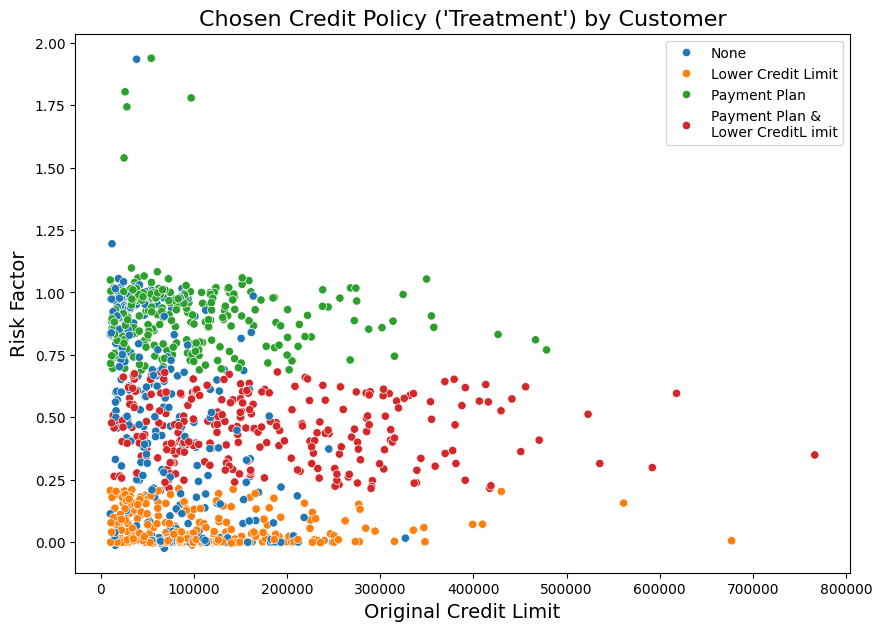

In [7]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
x=ccdefault_causal_df['_CC_LIMIT'].values,
y=ccdefault_causal_df['_risk_score'].values,
hue=all_treatment_names[ccdefault_causal_df['_TREATMENT'].values],
hue_order=all_treatment_names
)
plt.title("Chosen Credit Policy ('Treatment') by Customer", fontsize=16)
plt.xlabel("Original Credit Limit", fontsize=14)
plt.ylabel("Risk Factor", fontsize=14)
plt.show()

In [8]:
Y = ccdefault_causal_df[['_LTV']]#output
T = ccdefault_causal_df[['_TREATMENT']]
X = ccdefault_causal_df[['_CC_LIMIT']]#effect modifier
W = ccdefault_causal_df[['_spend','_tpm','_ppm','_RETAIL','_URBAN','_RURAL','_PREMIUM']]#confounders

In [9]:
!pip install econml dowhy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.4/174.4 kB 20.2 MB/s eta 0:00:00


In [10]:
from xgboost import XGBRegressor
from xgboost import XGBClassifier

In [11]:
from econml.dr import LinearDRLearner
drlearner = LinearDRLearner(
model_regression=XGBRegressor(learning_rate=0.1),
model_propensity=XGBClassifier(learning_rate=0.1, max_depth=2,
objective="multi:softmax"),random_state=9,
)

/usr/local/lib/python3.10/dist-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/usr/local/lib/python3.10/dist-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100, num_

In [12]:
causal_mdl = drlearner.dowhy.fit(Y, T, X=X, W=W,
outcome_names=Y.columns.to_list(),
treatment_names=T.columns.to_list(),
feature_names=X.columns.to_list(),
confounder_names=W.columns.to_list(),
target_units=X.iloc[:550].values)

econml has not been tested with dowhy versions >= 0.9
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


In [13]:
identified_ate = causal_mdl.identified_estimand_
print(identified_ate)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                                       
─────────────(E[_LTV|_URBAN,_PREMIUM,_RURAL,_RETAIL,_spend,_tpm,_CC_LIMIT,_ppm
d[_TREATMENT]                                                                 

  
])
  
Estimand assumption 1, Unconfoundedness: If U→{_TREATMENT} and U→_LTV then P(_LTV|_TREATMENT,_URBAN,_PREMIUM,_RURAL,_RETAIL,_spend,_tpm,_CC_LIMIT,_ppm,U) = P(_LTV|_TREATMENT,_URBAN,_PREMIUM,_RURAL,_RETAIL,_spend,_tpm,_CC_LIMIT,_ppm)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [14]:
drlearner_estimate = causal_mdl.estimate_
print(drlearner_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                                       
─────────────(E[_LTV|_URBAN,_PREMIUM,_RURAL,_RETAIL,_spend,_tpm,_CC_LIMIT,_ppm
d[_TREATMENT]                                                                 

  
])
  
Estimand assumption 1, Unconfoundedness: If U→{_TREATMENT} and U→_LTV then P(_LTV|_TREATMENT,_URBAN,_PREMIUM,_RURAL,_RETAIL,_spend,_tpm,_CC_LIMIT,_ppm,U) = P(_LTV|_TREATMENT,_URBAN,_PREMIUM,_RURAL,_RETAIL,_spend,_tpm,_CC_LIMIT,_ppm)

## Realized estimand
b: _LTV~_TREATMENT+_URBAN+_PREMIUM+_RURAL+_RETAIL+_spend+_tpm+_CC_LIMIT+_ppm | _CC_LIMIT
Target units: 

## Estimate
Mean value: 7262.731521219771
Effect estimates: [[6677.88929762]
 [7401.38722767]
 [7434.26840489]
 ...
 [7258.05122224]
 [7608.37299791]
 [7254.49823059]]



In [17]:
idxs = np.arange(0, causal_mdl._d_t[0]) # 3 TREATMENTS
print("idxs\n",idxs)
coefs = np.hstack([causal_mdl.coef_(T=i+1) for i in idxs])
print("coefs\n",coefs)
intercepts = np.hstack([causal_mdl.intercept_(T=i+1) for i in idxs])
print("intercepts\n",intercepts)

idxs
 [0 1 2]
coefs
 [0.00975506 0.04181064 0.0673408 ]
intercepts
 [6289.05970464 1241.88773716 5571.29608416]


In [15]:
cost_fn = lambda X: np.repeat(np.array([[0, 100, 100]]), X.shape[0], axis=0) +\
(np.repeat(np.array([[30, 0, 30]]), X.shape[0], axis=0) *\
X._ppm.values.reshape(-1,1))


In [18]:
treatment_effect_minus_costs = causal_mdl.const_marginal_effect(X=X.values) -\
cost_fn(ccdefault_causal_df)
treatment_effect_minus_costs = np.hstack([np.zeros(X.shape), treatment_effect_minus_costs])
recommended_T = np.argmax(treatment_effect_minus_costs, axis=1)

In [19]:
recommended_T

array([3, 3, 3, ..., 3, 3, 3])

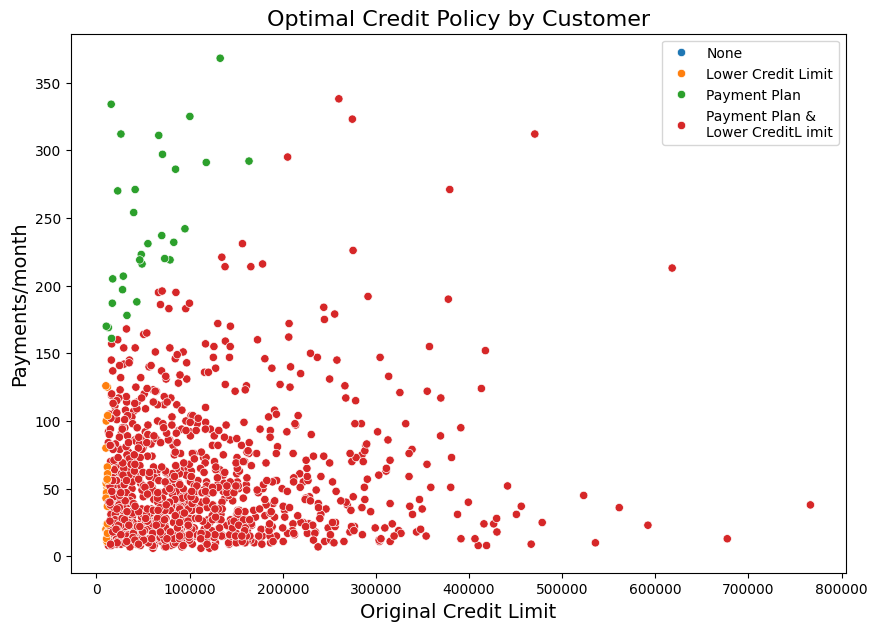

In [ ]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
x=ccdefault_causal_df['_CC_LIMIT'].values,
y=ccdefault_causal_df["_ppm"].values,
hue=all_treatment_names[recommended_T],
hue_order=all_treatment_names
)
plt.title("Optimal Credit Policy by Customer", fontsize=16)
plt.xlabel("Original Credit Limit", fontsize=14)
plt.ylabel("Payments/month", fontsize=14)
plt.show()

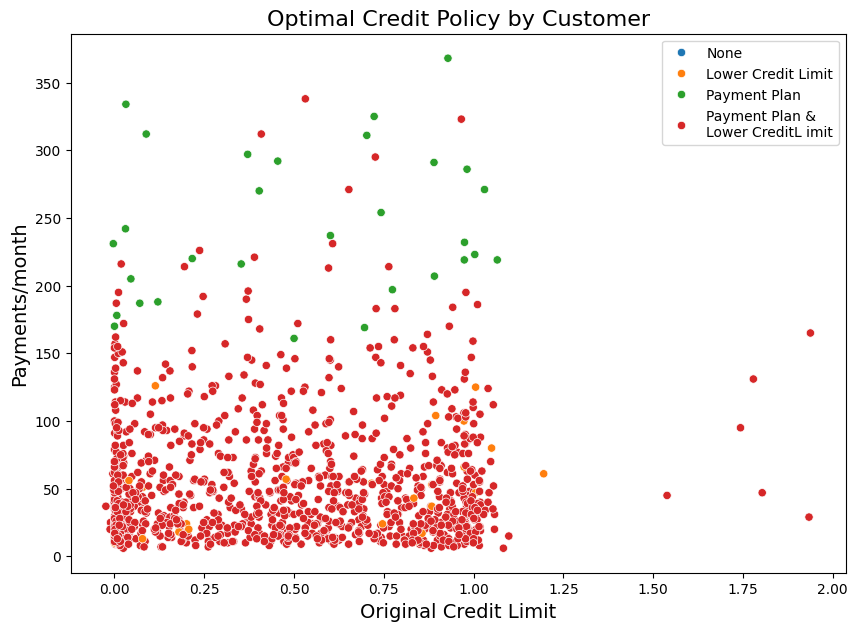

In [ ]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
x=ccdefault_causal_df['_risk_score'].values,
y=ccdefault_causal_df["_ppm"].values,
hue=all_treatment_names[recommended_T],
hue_order=all_treatment_names
)
plt.title("Optimal Credit Policy by Customer", fontsize=16)
plt.xlabel("Original Credit Limit", fontsize=14)
plt.ylabel("Payments/month", fontsize=14)
plt.show()